In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import re
import itertools
import time
import joblib
import random
import itertools
import pickle

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
pd.options.display.precision = 3
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import matplotlib.pyplot as plt
from matplotlib import container
from matplotlib.lines import Line2D

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets

In [3]:
import parsl
parsl.clear()

#from polyfuse.configs.igsb import config
from polyfuse.configs.igsb_jupyter import config
parsl.load(config)

from polyfuse import apps, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
model_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/models'
data_dir = '/cephfs/users/annawoodard/fusion-simulation/data/processed/'
training_fraction = 0.85

In [5]:
truth = apps.concatenate_true_fusions(os.path.join(data_dir, '*'), out_dir)

In [6]:
truth = pd.read_hdf(truth.result(), 'data')

In [7]:
truth

,gene_id_pair,left_gene_id,right_gene_id,left_gene_name,right_gene_name,fusion,sample
0,ENSG00000196155.13--ENSG00000138757.14,ENSG00000196155.13,ENSG00000138757.14,AC040160.1,G3BP2,AC040160.1--G3BP2,LIB-03335WT
1,ENSG00000254206.5--ENSG00000127580.17,ENSG00000254206.5,ENSG00000127580.17,NPIPB11,WDR24,NPIPB11--WDR24,LIB-03335WT
2,ENSG00000284776.1--ENSG00000114638.8,ENSG00000284776.1,ENSG00000114638.8,AL121900.1,UPK1B,AL121900.1--UPK1B,LIB-03335WT
3,ENSG00000069345.12--ENSG00000124449.7,ENSG00000069345.12,ENSG00000124449.7,DNAJA2,IRGC,DNAJA2--IRGC,LIB-03335WT
4,ENSG00000248099.4--ENSG00000261459.1,ENSG00000248099.4,ENSG00000261459.1,INSL3,AC002310.4,INSL3--AC002310.4,LIB-03335WT
...,...,...,...,...,...,...,...
495,ENSG00000089775.11--ENSG00000168427.9,ENSG00000089775.11,ENSG00000168427.9,ZBTB25,KLHL30,ZBTB25--KLHL30,LIB-006806wt
496,ENSG00000283992.2--ENSG00000134744.14,ENSG00000283992.2,ENSG00000134744.14,SLURP2,TUT4,SLURP2--TUT4,LIB-006806wt
497,ENSG00000172350.10--ENSG00000143195.13,ENSG00000172350.10,ENSG00000143195.13,ABCG4,ILDR2,ABCG4--ILDR2,LIB-006806wt
498,ENSG00000142684.9--ENSG00000124743.6,ENSG00000142684.9,ENSG00000124743.6,ZNF593,KLHL31,ZNF593--KLHL31,LIB-006806wt


In [8]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly', 'mapsplice2']

In [9]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [10]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [11]:
samples = sorted(caller_data['sample'].unique())
#random.shuffle(samples)
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [20]:
start = time.time()
x_train, y_train = apps.assemble_data(training_samples, callers, out_dir, encoded_features=encoded_features, extra_features=extra_features)
print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 66.6s


fit models in 185.6s


/cephfs/users/annawoodard/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


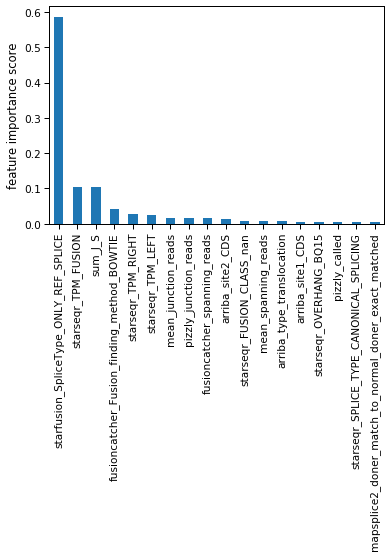

In [22]:
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)

base_columns = ['mean_spanning_reads', 'mean_junction_reads']
for c in callers:
    base_columns += [c + '_called', c + '_spanning_reads', c + '_junction_reads']
# below give 5 missing cancer cell line fusions compared with 7
#optimized_features = [
#    'starseqr_called', 'starseqr_spanning_reads', 'starseqr_junction_reads',
#    'starfusion_spanning_reads', 'starfusion_junction_reads', 'arriba_spanning_reads',
#    'fusioncatcher_called', 'fusioncatcher_spanning_reads', 'fusioncatcher_junction_reads',
#    'pizzly_called', 'pizzly_spanning_reads', 'pizzly_junction_reads', 'mapsplice2_spanning_reads',
#    'mapsplice2_junction_reads', 'starfusion_FFPM', 'starfusion_RightBreakEntropy', 'arriba_coverage1', 'arriba_coverage2', 'arriba_confidence_low'
#]
optimized_features = [
    'mean_spanning_reads', 'mean_junction_reads', 'fusioncatcher_spanning_reads', 
    'pizzly_called', 'pizzly_junction_reads', 'starseqr_OVERHANG_BQ15', 'starseqr_TPM_FUSION', 
    'starseqr_TPM_LEFT', 'starseqr_TPM_RIGHT', 'sum_J_S', 'fusioncatcher_Fusion_finding_method_BOWTIE', 
    'starseqr_FUSION_CLASS_nan', 'starseqr_SPLICE_TYPE_CANONICAL_SPLICING', 
    'mapsplice2_doner_match_to_normal_doner_exact_matched', 'starfusion_SpliceType_ONLY_REF_SPLICE', 
    'arriba_site1_CDS', 'arriba_site2_CDS', 'arriba_type_translocation'
]
classifiers = []
for features in [
            #base_columns,
            optimized_features
        ]:
    #label = 'LSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.LinearSVC(probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
    #classifiers += [(features, label, trans)]


    #label = 'DefaultSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(probability=True)
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
    #classifiers += [(features, label, trans)]

    #label = 'SVC{}Features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(C=10, gamma='auto', probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
    #classifiers += [(features, label, trans)]
    
    #label = 'RFC{}F'.format(len(features))
    #trans = 'noop'
    #classifier = ensemble.RandomForestClassifier()
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
    #classifiers += [(features, label, trans)]

    
    label = 'GBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250, subsample=1.)
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
    classifiers += [(features, label, trans)]
    
    plt.figure()
    feature_importances = pd.Series(classifier.feature_importances_, features).sort_values(ascending=False)
    feature_importances.plot(kind='bar')
    plt.ylabel('feature importance score')

    label = 'DefaultGBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
    classifiers += [(features, label, trans)]
    

print('fit models in {:.1f}s'.format((time.time() - start)))

In [23]:
with open(os.path.join(model_dir, 'classifiers.pkl'), 'wb') as f:
    pickle.dump(classifiers, f)

In [52]:
start = time.time()
consensus_data = pd.read_hdf(
    apps.predict_consensus(testing_samples, out_dir, callers, [2, 3, 4, 5, 6, 7]), 'data'
)
print('assembled consensus predictions in {:.1f}s'.format((time.time() - start)))

start = time.time()
consensus = ['ConsensusQ5', 'ConsensusQ4', 'ConsensusQ3']
model_data = pd.read_hdf(
    apps.predict(testing_samples, out_dir, model_dir, classifiers, callers, consensus=consensus), 'data'
)
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled consensus predictions in 0.9s
assembled predictions in 53.1s


In [53]:
summary = apps.make_summary(out_dir, testing_samples)

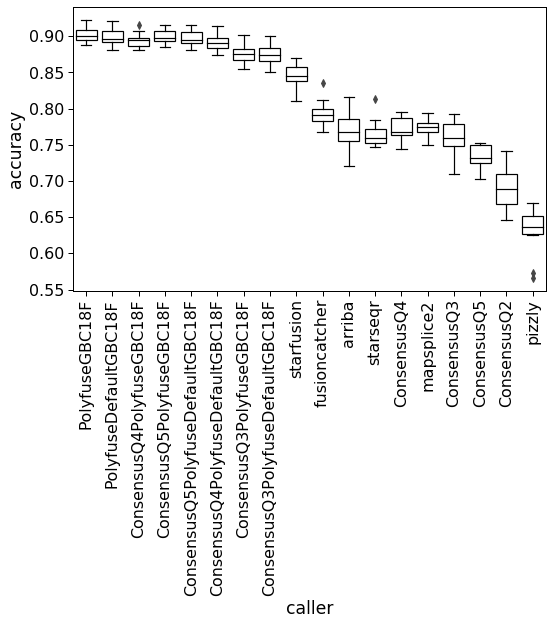

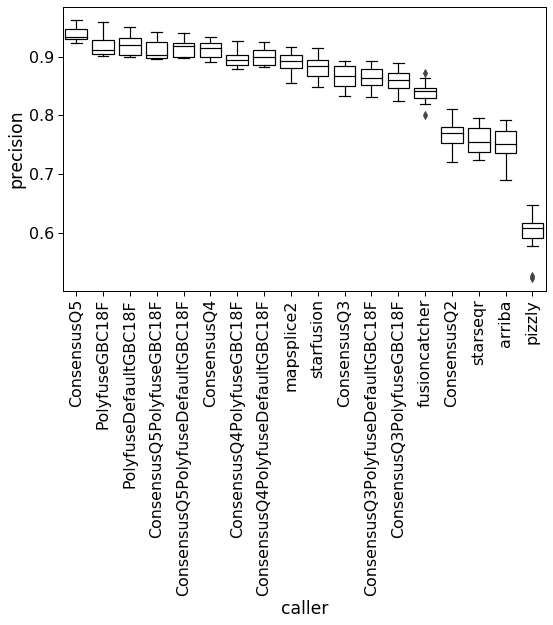

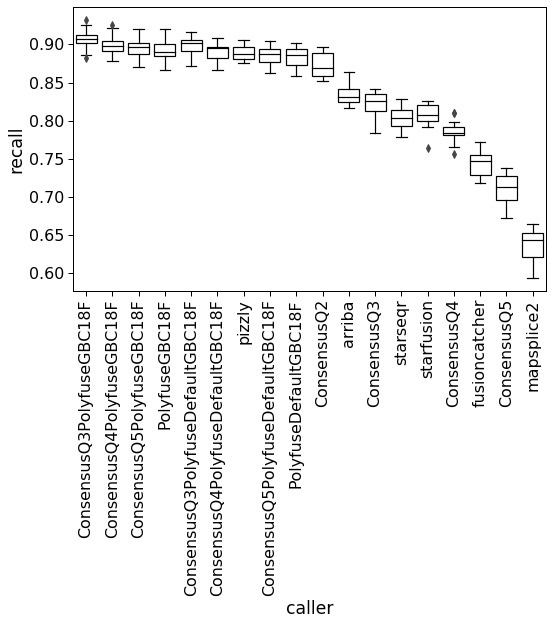

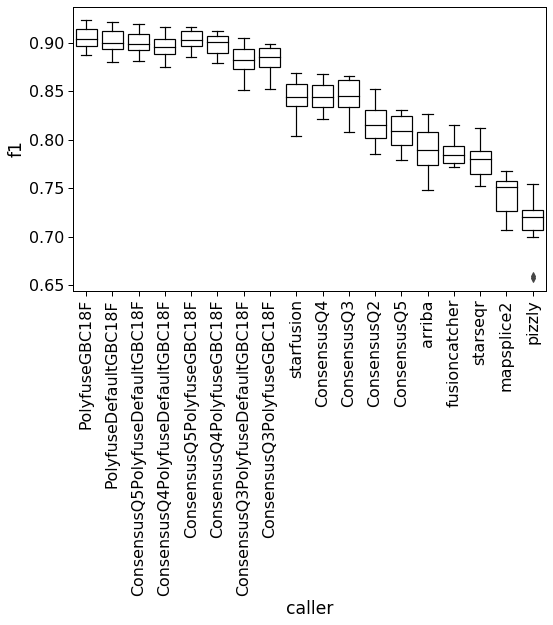

In [54]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.figure(figsize=(8, 9))
    #plt.figure()
    #sorted_index = summary[metric].median().sort_values().index
    #print(sorted_index)
    ax = sns.boxplot(x="caller", y=metric, data=summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

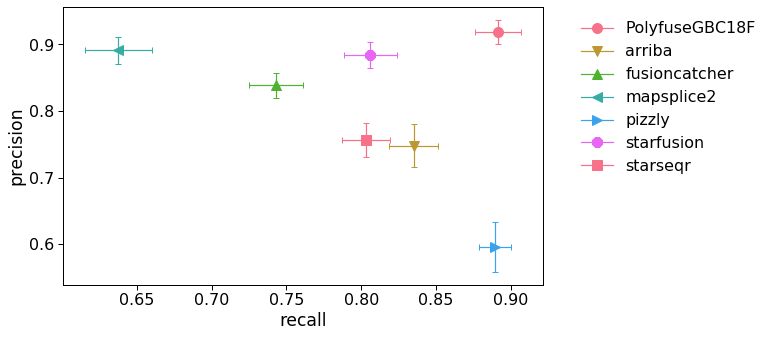

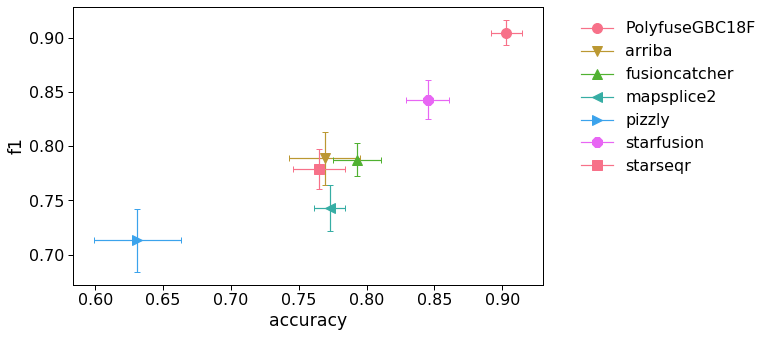

In [35]:
sns.set_context('paper', font_scale=1.8)

#markers = itertools.cycle(Line2D.filled_markers)
markers = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'D'))
markers = itertools.cycle(Line2D.filled_markers[:len(means)])
sns.set_palette(sns.diverging_palette(145, 280, s=85, l=25, n=8, center='dark'))
sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=9, center='dark'))
sns.set_palette("husl")

filter_regex = 'PolyfuseDefaultGBC17F|PolyfuseDefaultGBC19F|PolyfuseGBC17F|ConsensusQ3|ConsensusQ4'
top_model_summary = summary[~summary.caller.str.contains(filter_regex)]
top_model_summary = summary[summary.caller.isin(callers + ['PolyfuseGBC18F'])]
means = top_model_summary.groupby('caller').mean()
stds = top_model_summary.groupby('caller').std()

for x, y in [('recall', 'precision'), ('accuracy', 'f1')]:
    fig, ax = plt.subplots(figsize=(11, 5))

    for caller in means.index:
        plt.errorbar(
            [means.loc[caller][x]],
            [means.loc[caller][y]],
            xerr=stds.loc[caller][x],
            yerr=stds.loc[caller][y],
            label=caller,
            marker=next(markers),
            markersize=10,
            capsize=3
        )
        
    plt.xlabel(x)
    plt.ylabel(y)
    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), frameon=False)
    #plt.tight_layout()
    plt.savefig('plots/{}_vs_{}.pdf'.format(x, y))
    

In [32]:
pd.options.display.max_rows = 200
summary.groupby('caller').mean().sort_values(by='accuracy', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
PolyfuseGBC18F,445.667,39.583,54.333,430.417,0.891,0.919,0.903,0.905,0.806
PolyfuseDefaultGBC18F,441.500,38.500,58.500,431.500,0.883,0.920,0.900,0.901,0.800
ConsensusQ5PolyfuseGBC18F,447.417,44.333,52.583,425.667,0.895,0.910,0.900,0.902,0.800
ConsensusQ5PolyfuseDefaultGBC18F,442.250,41.167,57.750,428.833,0.885,0.915,0.898,0.899,0.796
ConsensusQ4PolyfuseGBC18F,449.583,52.083,50.417,417.917,0.899,0.896,0.894,0.898,0.788
ConsensusQ4PolyfuseDefaultGBC18F,444.750,48.917,55.250,421.083,0.890,0.901,0.893,0.895,0.785
ConsensusQ3PolyfuseGBC18F,453.333,74.333,46.667,395.667,0.907,0.859,0.875,0.882,0.750
ConsensusQ3PolyfuseDefaultGBC18F,449.333,70.833,50.667,399.167,0.899,0.864,0.875,0.881,0.749
starfusion,403.083,53.167,96.917,416.833,0.806,0.884,0.845,0.843,0.693


In [33]:
summary.sort_values(by='accuracy', ascending=False)

,sample,caller,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
4,LIB-04653wt,PolyfuseGBC18F,445,19,55,436,0.890,0.959,0.923,0.923,0.848
1,LIB-04650wt,PolyfuseGBC18F,455,38,45,525,0.910,0.923,0.922,0.916,0.843
49,LIB-04650wt,PolyfuseDefaultGBC18F,447,31,53,532,0.894,0.935,0.921,0.914,0.842
25,LIB-04650wt,ConsensusQ4PolyfuseGBC18F,461,50,39,513,0.922,0.902,0.916,0.912,0.832
13,LIB-04650wt,ConsensusQ5PolyfuseGBC18F,456,45,44,518,0.912,0.910,0.916,0.911,0.832
...,...,...,...,...,...,...,...,...,...,...,...
156,LIB-04649wt,pizzly,442,287,58,143,0.884,0.606,0.629,0.719,0.262
158,LIB-04651wt,pizzly,446,328,54,195,0.892,0.576,0.627,0.700,0.309
167,LIB-04674wt,pizzly,440,300,60,162,0.880,0.595,0.626,0.710,0.274
159,LIB-04652wt,pizzly,439,396,61,173,0.878,0.526,0.572,0.658,0.220


In [ ]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auroc = metrics.roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='{} (AUROC = {:0.2f})'.format(caller, auroc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(frameon=False)
plt.savefig('plots/ROC.pdf')

In [ ]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    plt.plot(precision, recall, label='{} (AUPRC = {:0.2f})'.format(caller, auroc))

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(frameon=False)
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

In [37]:
sample = 'LIB-04674wt'
consensus = 'ConsensusQ5'
consensus_data.loc[(consensus_data['sample'] == sample) & (consensus_data.caller == consensus)]

,sample,caller,fusion
15025,LIB-04674wt,ConsensusQ5,NOX1--CEP295
15026,LIB-04674wt,ConsensusQ5,PAFAH2--CRB3
15027,LIB-04674wt,ConsensusQ5,MFSD12--KLRG1
15028,LIB-04674wt,ConsensusQ5,TBC1D21--AGK
15029,LIB-04674wt,ConsensusQ5,NUP188--CCR8
...,...,...,...
15402,LIB-04674wt,ConsensusQ5,FOSL2--ACSS1
15403,LIB-04674wt,ConsensusQ5,MYH7--BARHL2
15404,LIB-04674wt,ConsensusQ5,NAGLU--KIR3DL3
15405,LIB-04674wt,ConsensusQ5,MSRB2--SLC46A2


In [38]:
from polyfuse.utils import get_consensus

data = pd.read_hdf(os.path.join(out_dir, 'caller_data.hdf'))
cut_data = data.loc[data['sample'] == sample]
callsets = []
futures = []
for caller in callers:
    callsets.append(set(cut_data[cut_data.caller == caller].fusion))
for quorum in [1, 2, 3, 4, 5, 6, 7]:
    futures += [(get_consensus(callsets, quorum), quorum)]

In [39]:
for f, quorum in futures:
    consensus = f.result()
    print(len(consensus), quorum)

930 1
569 2
477 3
439 4
382 5
0 6
0 7
